<a href="https://colab.research.google.com/github/soliman787/Soft-Computing/blob/main/Copy_of_Soft_Computing_SVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df_raw = pd.read_csv('/content/crimedata.csv')

df_raw.head()

,communityName,state,countyCode,communityCode,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,11980,3.10,1.37,91.78,6.50,1.88,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,23123,2.82,0.80,95.57,3.44,0.85,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,29344,2.43,0.74,94.33,3.43,2.35,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,16656,2.40,1.70,97.35,0.50,0.70,...,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,11245,2.76,0.53,89.16,1.17,0.52,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [ ]:
df_raw.info()
df_raw.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 146 entries, communityName to nonViolPerPop
dtypes: float64(116), int64(28), object(2)
memory usage: 2.5+ MB


,0
communityName,object
state,object
countyCode,float64
communityCode,float64
population,int64
...,...
autoTheftPerPop,float64
arsons,float64
arsonsPerPop,float64
ViolentCrimesPerPop,float64


In [ ]:
!pip install deap
!pip install pyswarms

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from deap import base, creator, tools, algorithms

import pyswarms as ps

import matplotlib.pyplot as plt
import seaborn as sns
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
# Data Preprocessing
print("\n--- Data Preprocessing ---")


if 'ViolentCrimesPerPop' not in df_raw.columns:
    print("ERROR: 'ViolentCrimesPerPop' column not found. Please check column names.")

    if df_raw.shape[1] > 5:
        target_col_name = df_raw.columns[-1]
        print(f"Assuming '{target_col_name}' is the target variable based on position.")
        if df_raw[target_col_name].isnull().all():
             print(f"Target column {target_col_name} is all NaNs. Cannot proceed with it as target.")

             numeric_cols_for_target = df_raw.select_dtypes(include=np.number).columns
             if len(numeric_cols_for_target) > 0:
                 target_col_name = numeric_cols_for_target[0] # Take the first numeric one
                 print(f"WARNING: Using '{target_col_name}' as a fallback target. THIS IS LIKELY WRONG. Please verify.")
             else:
                 print("FATAL: No suitable numeric target column found. Please inspect your data.")
                 exit()
    else:
        print("FATAL: Cannot automatically determine target. Please inspect data.")
        exit()
else:
    target_col_name = 'ViolentCrimesPerPop'

df_raw.dropna(subset=[target_col_name], inplace=True)
print(f"Shape after dropping rows with missing target ({target_col_name}): {df_raw.shape}")

if df_raw.empty:
    print(f"FATAL: No data left after dropping NaNs in target column '{target_col_name}'. Check data quality.")
    exit()

median_crime = df_raw[target_col_name].median()
df_raw['crime_category'] = (df_raw[target_col_name] > median_crime).astype(int)
y = df_raw['crime_category']


--- Data Preprocessing ---
Shape after dropping rows with missing target (ViolentCrimesPerPop): (1994, 146)


In [ ]:
# 2. Select features (X) - drop original target, new categorical target, and non-predictive columns

cols_to_drop = [target_col_name, 'crime_category', 'communityname', 'state', 'county', 'community', 'fold']

cols_to_drop_existing = [col for col in cols_to_drop if col in df_raw.columns]
X = df_raw.drop(columns=cols_to_drop_existing)
print(f"Features selected. Shape of X: {X.shape}")

Features selected. Shape of X: (1994, 144)


In [ ]:

# Handle missing values in features (X) using median imputation
for col in X.columns:
    if X[col].dtype == 'object':
        try:
            X[col] = pd.to_numeric(X[col])
        except ValueError:
            print(f"Could not convert column {col} to numeric. It might contain non-numeric strings other than '?'. Dropping it.")
            X.drop(columns=[col], inplace=True)

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

print("Missing values handled. Shape of X after imputation:", X.shape)
if X.empty or X.shape[1] == 0:
    print("FATAL: No features remaining after preprocessing. Check data and column drop logic.")
    exit()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to preserve column names for feature selection steps
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)


print(f"Data split and scaled. X_train shape: {X_train_scaled_df.shape}, X_test shape: {X_test_scaled_df.shape}")

# Store results
results = {}

Missing values handled. Shape of X after imputation: (1994, 143)
Data split and scaled. X_train shape: (1395, 143), X_test shape: (599, 143)


In [ ]:
# Helper function to evaluate model
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    # print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
# Scenario 1 - Using original dataset with all available features

print("\n--- Scenario 1: Model with All Features ---")

model_all_features = SVC(kernel='linear', random_state=42, class_weight='balanced', C=1.0)
model_all_features.fit(X_train_scaled_df, y_train)
y_pred_all = model_all_features.predict(X_test_scaled_df)
results['All Features'] = evaluate_model(y_test, y_pred_all, "SVC (All Features)")

if hasattr(model_all_features, 'coef_'):
    importances_all = np.abs(model_all_features.coef_[0]) # Absolute values of coefficients for magnitude
    feature_names_all = X.columns
    feature_importance_df_all = pd.DataFrame({'feature': feature_names_all, 'importance': importances_all})
    feature_importance_df_all = feature_importance_df_all.sort_values(by='importance', ascending=False)
    print("\nTop 10 features (All Features Model - based on coefficient magnitude for linear SVC):")
    print(feature_importance_df_all.head(10))
else:
    print("Could not retrieve feature importances (coefficients). This model might not be linear SVC or coefficients are not exposed.")


--- Scenario 1: Model with All Features ---

--- SVC (All Features) ---
Accuracy: 0.9549
Precision: 0.9553
Recall: 0.9549
F1-Score: 0.9549

Top 10 features (All Features Model - based on coefficient magnitude for linear SVC):
             feature  importance
133    assaultPerPop    6.403910
131      robbbPerPop    3.107125
23       whitePerCap    0.881452
53          NumImmig    0.842497
31   PctLess9thGrade    0.723918
142    nonViolPerPop    0.605215
129      rapesPerPop    0.562305
11        agePct65up    0.510668
12         numbUrban    0.498164
2         population    0.487839


In [ ]:
print("\n--- Scenario 2: Feature Selection with Genetic Algorithm (GA) ---")

# GA Parameters
N_POPULATION = 30
N_GENERATIONS = 20
CXPB = 0.6
MUTPB = 0.2
N_FEATURES = X_train_scaled_df.shape[1]



if "FitnessMax" not in dir(creator):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if "Individual" not in dir(creator):
    creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, N_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


--- Scenario 2: Feature Selection with Genetic Algorithm (GA) ---


In [ ]:
# Evaluation function for GA
def evalFeatures(individual):
    selected_feature_indices = [i for i, bit in enumerate(individual) if bit == 1]
    if not selected_feature_indices:
        return 0,

    X_train_subset = X_train_scaled_df.iloc[:, selected_feature_indices]
    X_test_subset = X_test_scaled_df.iloc[:, selected_feature_indices]


    model = SVC(kernel='linear', random_state=42, class_weight='balanced', C=1.0)
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    return f1_score(y_test, y_pred, average='weighted', zero_division=0),

toolbox.register("evaluate", evalFeatures)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
# Run GA
print(f"Running GA with {N_POPULATION} individuals for {N_GENERATIONS} generations...")
population = toolbox.population(n=N_POPULATION)
# To track best fitness over generations
logbook = tools.Logbook()
logbook.header = "gen", "evals", "avg", "min", "max"
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)


for gen in range(N_GENERATIONS):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    record = stats.compile(population)
    logbook.record(gen=gen, evals=len(offspring), **record)
    print(logbook.stream)


best_individual_ga = tools.selBest(population, k=1)[0]
selected_features_ga_indices = [i for i, bit in enumerate(best_individual_ga) if bit == 1]

if not selected_features_ga_indices:
    print("GA selected no features. This can happen. Using all features as a fallback for this scenario.")
    X_train_ga_selected = X_train_scaled_df
    X_test_ga_selected = X_test_scaled_df
    selected_feature_names_ga = X.columns.tolist()
else:
    selected_feature_names_ga = X.columns[selected_features_ga_indices].tolist()
    X_train_ga_selected = X_train_scaled_df.iloc[:, selected_features_ga_indices]
    X_test_ga_selected = X_test_scaled_df.iloc[:, selected_features_ga_indices]

print(f"\nGA selected {len(selected_feature_names_ga)} features: {selected_feature_names_ga[:10]}...")

Running GA with 30 individuals for 20 generations...
gen	evals	avg     	min     	max     
0  	30   	0.947933	0.847804	0.974957
1  	30   	0.969836	0.948228	0.978296
2  	30   	0.973955	0.969946	0.978297
3  	30   	0.977239	0.966607	0.981636
4  	30   	0.979187	0.974957	0.981636
5  	30   	0.980746	0.974957	0.984974
6  	30   	0.981636	0.979966	0.984974
7  	30   	0.982526	0.979967	0.984974
8  	30   	0.983083	0.978297	0.984975
9  	30   	0.985086	0.981636	0.988314
10 	30   	0.985142	0.981636	0.988314
11 	30   	0.985754	0.983305	0.988314
12 	30   	0.986923	0.984974	0.988314
13 	30   	0.98759 	0.984974	0.988314
14 	30   	0.987813	0.983306	0.988314
15 	30   	0.988425	0.988314	0.989983
16 	30   	0.987924	0.976627	0.988314
17 	30   	0.988425	0.988314	0.989983
18 	30   	0.988536	0.988314	0.989983
19 	30   	0.988258	0.979966	0.989983

GA selected 66 features: ['communityCode', 'householdsize', 'racepctblack', 'racePctHisp', 'agePct12t29', 'agePct16t24', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage'

In [ ]:
# Train final model with GA selected features
model_ga = SVC(kernel='linear', random_state=42, class_weight='balanced', C=1.0)
model_ga.fit(X_train_ga_selected, y_train)
y_pred_ga = model_ga.predict(X_test_ga_selected)
results['GA Selected'] = evaluate_model(y_test, y_pred_ga, "SVC (GA Selected Features)")


if len(selected_feature_names_ga) > 0 and not X_train_ga_selected.empty and hasattr(model_ga, 'coef_') :
    importances_ga = np.abs(model_ga.coef_[0])
    feature_importance_df_ga = pd.DataFrame({'feature': selected_feature_names_ga, 'importance': importances_ga})
    feature_importance_df_ga = feature_importance_df_ga.sort_values(by='importance', ascending=False)
    print("\nTop 10 features (GA Selected Model - based on coefficient magnitude for linear SVC):")
    print(feature_importance_df_ga.head(10))
else:
    print("No features selected by GA, features dataframe is empty, or could not retrieve coefficients, skipping importance.")

if "FitnessMax" in dir(creator):
    del creator.FitnessMax
if "Individual" in dir(creator):
    del creator.Individual


--- SVC (GA Selected Features) ---
Accuracy: 0.9900
Precision: 0.9900
Recall: 0.9900
F1-Score: 0.9900

Top 10 features (GA Selected Model - based on coefficient magnitude for linear SVC):
           feature  importance
58   assaultPerPop    6.744935
57     robbbPerPop    3.812675
6        numbUrban    1.003303
65   nonViolPerPop    0.872630
18      PctFam2Par    0.655120
55     rapesPerPop    0.638904
60      larcPerPop    0.589096
39       RentHighQ    0.561550
34  PctHousNoPhone    0.485710
41       NumStreet    0.419265


In [ ]:
print("\n--- Scenario 3: Feature Selection with Particle Swarm Optimization (PSO) ---")

# PSO Parameters
N_PARTICLES = 30
N_ITERATIONS = 20 # PSO iterations
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': N_PARTICLES // 2, 'p': 2}

# Fitness function for PSO (PySwarms expects a cost function, so we minimize 1 - F1_score)
def pso_fitness_func(swarm_particle_matrix):
    costs = []
    for particle_idx in range(swarm_particle_matrix.shape[0]):
        particle = swarm_particle_matrix[particle_idx, :]
        selected_feature_indices = np.where(particle == 1)[0]

        if len(selected_feature_indices) == 0:
            costs.append(1.0)
            continue

        X_train_subset = X_train_scaled_df.iloc[:, selected_feature_indices]
        X_test_subset = X_test_scaled_df.iloc[:, selected_feature_indices]

        model = SVC(kernel='linear', random_state=42, class_weight='balanced', C=1.0)
        model.fit(X_train_subset, y_train)
        y_pred = model.predict(X_test_subset)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        costs.append(1.0 - f1) # Minimize 1 - F1 score
    return np.array(costs)


--- Scenario 3: Feature Selection with Particle Swarm Optimization (PSO) ---


In [ ]:
# Initialize BinaryPSO
optimizer = ps.discrete.BinaryPSO(n_particles=N_PARTICLES, dimensions=N_FEATURES, options=options)

# Perform optimization
print(f"Running PSO with {N_PARTICLES} particles for {N_ITERATIONS} iterations...")
cost, best_pos_pso = optimizer.optimize(pso_fitness_func, iters=N_ITERATIONS, verbose=True)

selected_features_pso_indices = np.where(best_pos_pso == 1)[0]

if len(selected_features_pso_indices) == 0:
    print("PSO selected no features. Using all features as a fallback.")
    X_train_pso_selected = X_train_scaled_df
    X_test_pso_selected = X_test_scaled_df
    selected_feature_names_pso = X.columns.tolist()
else:
    selected_feature_names_pso = X.columns[selected_features_pso_indices].tolist()
    X_train_pso_selected = X_train_scaled_df.iloc[:, selected_features_pso_indices]
    X_test_pso_selected = X_test_scaled_df.iloc[:, selected_features_pso_indices]

print(f"\nPSO selected {len(selected_feature_names_pso)} features: {selected_feature_names_pso[:10]}...")

# Train final model with PSO selected features
model_pso = SVC(kernel='linear', random_state=42, class_weight='balanced', C=1.0)
model_pso.fit(X_train_pso_selected, y_train)
y_pred_pso = model_pso.predict(X_test_pso_selected)
results['PSO Selected'] = evaluate_model(y_test, y_pred_pso, "SVC (PSO Selected Features)")

if len(selected_feature_names_pso) > 0 and not X_train_pso_selected.empty and hasattr(model_pso, 'coef_'):
    importances_pso = np.abs(model_pso.coef_[0])
    feature_importance_df_pso = pd.DataFrame({'feature': selected_feature_names_pso, 'importance': importances_pso})
    feature_importance_df_pso = feature_importance_df_pso.sort_values(by='importance', ascending=False)
    print("\nTop 10 features (PSO Selected Model - based on coefficient magnitude for linear SVC):")
    print(feature_importance_df_pso.head(10))
else:
    print("No features selected by PSO, features dataframe is empty, or could not retrieve coefficients, skipping importance.")

2025-05-15 23:55:04,866 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 15, 'p': 2}


Running PSO with 30 particles for 20 iterations...


pyswarms.discrete.binary: 100%|██████████|20/20, best_cost=0.00835
2025-05-15 23:56:03,588 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.008347245409014992, best pos: [0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0
 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1
 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0
 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0]



PSO selected 74 features: ['householdsize', 'racePctHisp', 'agePct12t21', 'numbUrban', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire']...

--- SVC (PSO Selected Features) ---
Accuracy: 0.9917
Precision: 0.9917
Recall: 0.9917
F1-Score: 0.9917

Top 10 features (PSO Selected Model - based on coefficient magnitude for linear SVC):
          feature  importance
70  assaultPerPop    6.829870
68    robbbPerPop    4.016641
3       numbUrban    0.801709
30   PctRecImmig8    0.749748
67    rapesPerPop    0.670719
10      medFamInc    0.539564
28  PctImmigRec10    0.498609
0   householdsize    0.491536
69       assaults    0.470397
11      perCapInc    0.468273



--- Performance Summary ---
              accuracy  precision    recall        f1
All Features  0.954925   0.955334  0.954925  0.954914
GA Selected   0.989983   0.990005  0.989983  0.989983
PSO Selected  0.991653   0.991658  0.991653  0.991653


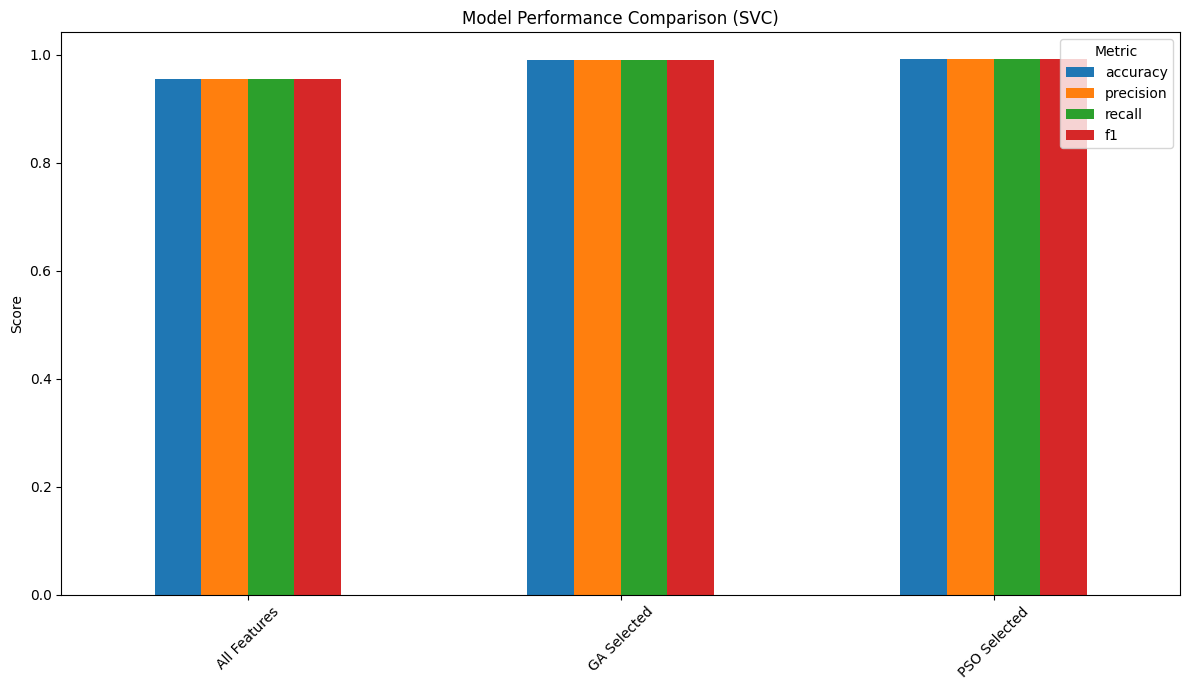

In [ ]:
# Summarize and Compare Performance

print("\n--- Performance Summary ---")
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1']]

print(results_df)

# Bar chart for comparison
results_df.plot(kind='bar', figsize=(12, 7))

plt.title('Model Performance Comparison (SVC)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()

plt.savefig('performance_comparison_chart_svc.png')
plt.show()

In [ ]:
print("\n--- Project Documentation Placeholders ---")
# MODIFIED: Updated for Support Vector Classifier (SVC)
print("\n1. ML Algorithm (Support Vector Classifier - SVC):")
print("   - Flowchart: [Conceptual: Data (Features X, Target y)] -> [Map data to higher-dimensional space (optional, via Kernel)] -> ")
print("                [Find Optimal Hyperplane that maximizes margin between classes] ->")
print("                [Hyperplane defined by Support Vectors (data points closest to margin)] ->")
print("                [Optimization Problem (e.g., Quadratic Programming) to find w, b for y(wx+b) >= 1] ->")
print("                [Trained Model (Support Vectors, w, b, kernel params)] -> [Prediction on New Data (based on side of hyperplane)]")
print("   - Pseudocode (Conceptual for Linear SVC Training):")
print("     Algorithm SVCTrainLinear(TrainingSet D(X,y), RegularizationParam C):")
print("       // Objective: Minimize 0.5 * ||w||^2 + C * sum(slack_variables_i)")
print("       // Subject to: y_i * (dot_product(w, x_i) + b) >= 1 - slack_variable_i,  slack_variable_i >= 0")
print("       Solve the constrained optimization problem for w (weight vector) and b (bias).")
print("         // This is typically done using QP solvers or specialized algorithms like SMO for non-linear kernels.")
print("       Identify Support Vectors (data points (x_i, y_i) for which y_i * (dot_product(w, x_i) + b) approx 1).")
print("       Return w, b (and support vectors, kernel parameters if non-linear).")
print("")
print("     To predict for instance x_new with trained w, b (Linear SVC):")
print("       decision_value = dot_product(w, x_new) + b")
print("       Return class_label_1 if decision_value >= 0 else class_label_0 (or sign(decision_value))")
print("     (For non-linear SVC, prediction involves kernel function with support vectors)")

print("\n2. GA Optimization Algorithm Process:")
print("   - Flowchart: [Conceptual: Initialize Population -> Evaluate Fitness -> Selection -> Crossover -> Mutation -> New Population -> Repeat until termination]")
print("   - Pseudocode (for feature selection):")
print("     Algorithm GeneticAlgorithmFeatureSelection(Features, Target, PopSize, Generations):")
print("       Initialize Population P with random binary strings (individuals, representing feature subsets)")
print("       For g = 1 to Generations:")
print("         For each individual I in P:")
print("           Fitness(I) = EvaluateMLModel(Features_selected_by_I, Target) // e.g., F1-score of SVC")
print("         P_selected = SelectParents(P, Fitness_values) // e.g., Tournament, Roulette Wheel")
print("         P_offspring = Crossover(P_selected) // e.g., One-point, Two-point")
print("         P_mutated = Mutate(P_offspring) // e.g., Bit-flip")
print("         P = P_mutated (or combine with P_selected for elitism)")
print("       Return BestIndividual(P) // Individual with highest fitness")

print("\n3. PSO Optimization Algorithm Process:")
print("   - Flowchart: [Conceptual: Initialize Particles (positions, velocities) -> Evaluate Fitness -> Update Personal Best & Global Best -> Update Velocities -> Update Positions -> Repeat until termination]")
print("   - Pseudocode (for feature selection):")
print("     Algorithm PSOFeatureSelection(Features, Target, NumParticles, Iterations):")
print("       Initialize Particles (random binary positions for feature subsets, random velocities)")
print("       Initialize pBest_positions = current_positions, pBest_fitness = fitness of current_positions")
print("       Initialize gBest_position = best_among_pBests, gBest_fitness = best_among_pBest_fitness")
print("       For iter = 1 to Iterations:")
print("         For each particle i:")
print("           CurrentFitness_i = EvaluateMLModel(Features_selected_by_particle_i_position, Target) // e.g., F1-score of SVC")
print("           If CurrentFitness_i is better than pBest_fitness_i:")
print("             pBest_position_i = particle_i_position")
print("             pBest_fitness_i = CurrentFitness_i")
print("           If CurrentFitness_i is better than gBest_fitness:")
print("             gBest_position = particle_i_position")
print("             gBest_fitness = CurrentFitness_i")
print("         For each particle i:")
print("           Update_velocity(particle_i, pBest_position_i, gBest_position, inertia_w, c1, c2)")
print("           Update_position(particle_i) // Apply sigmoid to velocity for binary position update, ensure binary {0,1}")
print("       Return gBest_position")


print("\n5. Block diagram of the implemented system:")
# MODIFIED: Updated for SVC
print("   [Raw CSV Data] -> [Preprocessing (Handle Missing Values, Impute NaNs, Create Target Variable 'crime_category', Scale Features)] -> ")
print("     |--> [Scenario 1: Train SVC (kernel='linear') with All Scaled Features] --> [Evaluate Model 1 (Metrics: Acc, Prec, Rec, F1)]")
print("     |--> [Scenario 2: GA for Feature Selection on Scaled Features] -> [Identify GA-Selected Features] -> [Train SVC (kernel='linear') with GA-Selected Scaled Features] --> [Evaluate Model 2 (Metrics)]")
print("     |--> [Scenario 3: PSO for Feature Selection on Scaled Features] -> [Identify PSO-Selected Features] -> [Train SVC (kernel='linear') with PSO-Selected Scaled Features] --> [Evaluate Model 3 (Metrics)]")
print("     --> [Compare Metrics & Visualize Performance (Bar Chart)]")


--- Project Documentation Placeholders ---

1. ML Algorithm (Support Vector Classifier - SVC):
   - Flowchart: [Conceptual: Data (Features X, Target y)] -> [Map data to higher-dimensional space (optional, via Kernel)] -> 
                [Find Optimal Hyperplane that maximizes margin between classes] ->
                [Hyperplane defined by Support Vectors (data points closest to margin)] ->
                [Optimization Problem (e.g., Quadratic Programming) to find w, b for y(wx+b) >= 1] ->
                [Trained Model (Support Vectors, w, b, kernel params)] -> [Prediction on New Data (based on side of hyperplane)]
   - Pseudocode (Conceptual for Linear SVC Training):
     Algorithm SVCTrainLinear(TrainingSet D(X,y), RegularizationParam C):
       // Objective: Minimize 0.5 * ||w||^2 + C * sum(slack_variables_i)
       // Subject to: y_i * (dot_product(w, x_i) + b) >= 1 - slack_variable_i,  slack_variable_i >= 0
       Solve the constrained optimization problem for w (weight vecto